<a href="https://colab.research.google.com/github/Madhusudhanbandi/EVA-S10/blob/master/EVA_S10_ASSIG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
import torchvision
from torchsummary import summary
from myfunctions import *
from transforms_dataloading import downloading_data_transforms_albumentations
from tqdm import tqdm

from albumentations import  ( 
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose , Normalize ,ToFloat, Cutout
)

import cv2

import numpy as np

from albumentations.pytorch import  ToTensor 

**Downloading datasets and applying transforms**

In [0]:
trainset,testset =downloading_data_transforms_albumentations(datasets.CIFAR10)

Files already downloaded and verified
Files already downloaded and verified
No.of images in train set are 50000
No.of images in test set are 10000


**Loading data to train and test loader**

In [0]:
trainloader,testloader=loading_to_train_test_loader(1,trainset,testset)


CUDA Available? True
Train and Test data loaded.......


**Building model network**

In [0]:
ResNet18=Build_your_ResNetmodel([2,2,2,2])

**Adding model to device**

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18.to(device)
summary(model,input_size=(3,32,32))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

**LR Finder**

  pip install torch-lr-finder -v --global-option="amp"



Learning rate search finished. See the graph with {finder_name}.plot()


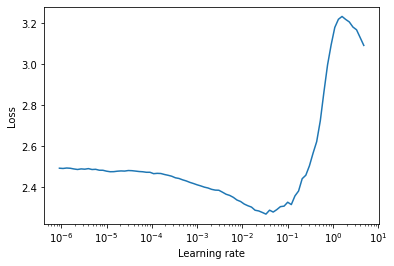

In [0]:
!pip install torch-lr-finder
from torch_lr_finder import LRFinder
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

**Defining optimizer and Training model**

In [0]:

import torch.optim as optim
train_los=[]
train_acs=[]
test_los=[]
test_acs=[]
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_losses,train_acces=training_model_with_scheduler(model, device, trainloader, optimizer)
    train_los.append(train_losses)
    train_acs.append(train_acces)
    test_losses, test_acces=testing_model(model, device, testloader)
    test_los.append(test_losses)
    test_acs.append(test_acces)

EPOCH: 0

Train set: Average loss: 6.4653, Train Accuracy: (51.63%)


Test set: Average Loss: 5.5038, Test Accuracy: 5923/10000 (59.23%)

EPOCH: 1

Train set: Average loss: 5.1526, Train Accuracy: (62.34%)


Test set: Average Loss: 4.6645, Test Accuracy: 6709/10000 (67.09%)

EPOCH: 2

Train set: Average loss: 4.4165, Train Accuracy: (67.87%)


Test set: Average Loss: 4.2075, Test Accuracy: 7156/10000 (71.56%)

EPOCH: 3

Train set: Average loss: 3.7446, Train Accuracy: (72.87%)


Test set: Average Loss: 3.6586, Test Accuracy: 7533/10000 (75.33%)

EPOCH: 4

Train set: Average loss: 3.3154, Train Accuracy: (76.08%)


Test set: Average Loss: 3.0967, Test Accuracy: 7844/10000 (78.44%)

EPOCH: 5

Train set: Average loss: 2.9636, Train Accuracy: (78.61%)


Test set: Average Loss: 2.8040, Test Accuracy: 8045/10000 (80.45%)

EPOCH: 6

Train set: Average loss: 2.7046, Train Accuracy: (80.32%)


Test set: Average Loss: 2.7096, Test Accuracy: 8112/10000 (81.12%)

EPOCH: 7

Train set: Average loss:

**Loss and Accuracy graphs**

In [0]:
import pandas as pd
tr_lo_df=pd.DataFrame(train_los,columns=['Loss'])
ts_lo_df=pd.DataFrame(test_los,columns=['Loss'])
tr_ac_df=pd.DataFrame(train_acs,columns=['acc'])
ts_ac_df=pd.DataFrame(test_acs,columns=['acc'])

Text(0.5, 1.0, 'Train Test Accuracy')

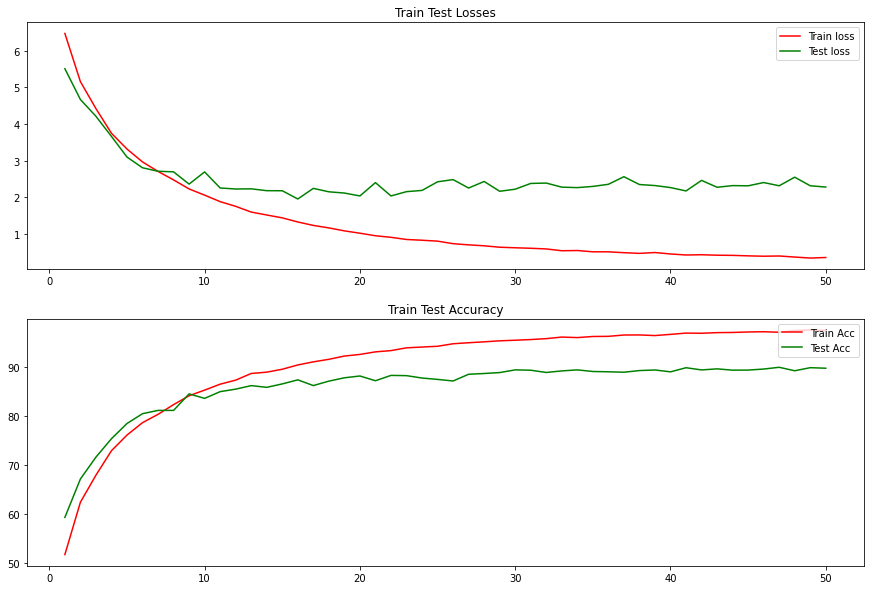

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(tr_lo_df.index+1,tr_lo_df['Loss'],color='red')
axs[0].plot(ts_lo_df.index+1,ts_lo_df['Loss'],color='green')

axs[0].legend(['Train loss','Test loss'], loc='upper right')
axs[0].set_title("Train Test Losses")
# axs[0].set_ylim([-100,800])


axs[1].plot(tr_ac_df.index+1,tr_ac_df['acc'],color='red')
axs[1].plot(ts_ac_df.index+1,ts_ac_df['acc'],color='green')

axs[1].legend(['Train Acc','Test Acc'], loc='upper right')
axs[1].set_title("Train Test Accuracy")

**Miss classified Images**

In [0]:
incorrect_images,incorrect_images_label,incorrect_images_predl=get_miss_classified_images(model,device,testloader)

<Figure size 432x288 with 0 Axes>

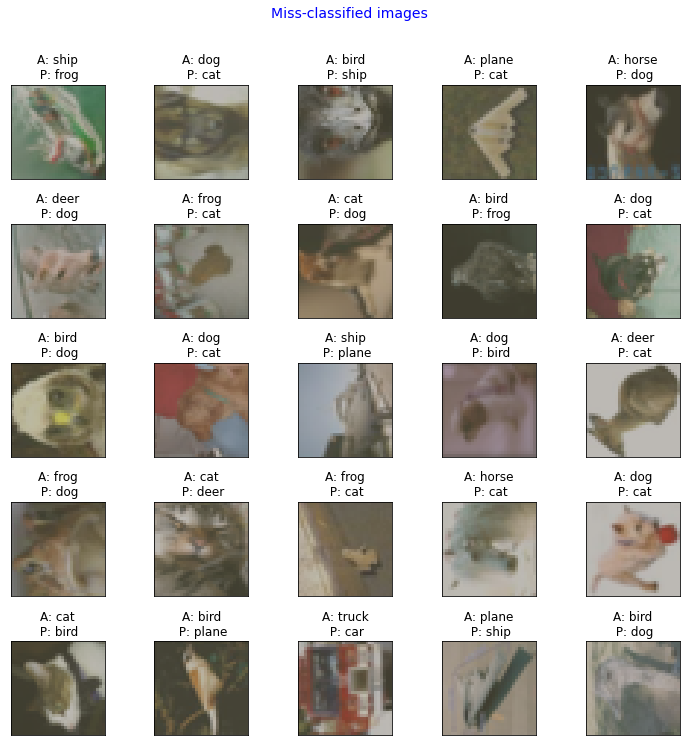

In [0]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt

unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std= (0.2471, 0.2435, 0.2616))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

fig = plt.figure()
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(unorm(imgs[i]).permute(2, 1, 0).numpy(), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

